In [34]:
import numpy as np
import pandas as pd

import os
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import statannot

from sklearn.utils import resample
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from lifelines.utils import concordance_index
from xgboost import XGBRegressor,XGBClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from keras.models import Sequential
from keras.layers import Dense, Dropout

from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,f_oneway,kruskal


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, make_scorer,precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
from abc import ABC, abstractmethod

import shap

import warnings
warnings.filterwarnings("ignore")


# Prepare Data

In [35]:
metab_df=pd.read_csv('../data/Using/metab.csv',index_col=0)
sample_df=pd.read_csv('../data/Using/sample.csv',index_col=0)
sample_info=pd.read_csv('../../MultiOmics/data/sample/personal_info.csv',index_col=0)
lipid_df=pd.read_csv('../data/Using/lipid.csv',index_col=0)
# sample_df=chemical_sample_df
# sample_df.set_index("Sample Name",inplace=True)
metab_cluster=pd.read_csv('../data/metab/cluster_result.csv',index_col=0)
lipid_cluster=pd.read_csv('../data/lipid/cluster_result.csv',index_col=0)
metab_num=metab_df.shape[1]
lipid_num=lipid_df.shape[1]

sample_df=sample_df.rename(columns={'TMN':'TNM'})

sample_df=pd.merge(sample_df,sample_info.iloc[:,1:],left_index=True,right_index=True)

In [36]:
metab_cluster

,nmf_3_clusters,kmeans_3_clusters,nmf_2_clusters,kmeans_2_clusters,batch
1452,1,1,1,1,1
8339,1,1,1,1,1
5608,1,1,1,1,1
8232,3,3,2,2,1
8775,2,3,2,2,1
...,...,...,...,...,...
140143-T,1,2,1,1,2
190040-T,1,2,1,1,2
190161-T,3,2,2,1,2
200288-T,3,2,2,2,2


In [37]:
sample_df['metab_cluster']=metab_cluster['kmeans_2_clusters'].reindex(sample_df.index)
sample_df['lipid_cluster']=lipid_cluster['kmeans_2_clusters'].reindex(sample_df.index)

## Save

In [38]:
# sample_df.iloc[:,1:].to_excel('../data/Using/whole_sample_info.xlsx')

In [39]:
sample_df=sample_df.dropna(axis=0,how='any',subset=['lipid_cluster','metab_cluster'])

In [40]:
sample_df

,Unnamed: 0,hospital_id,Name,batch,os,oss,type,TNM,主要分型,次要分型,...,状态,生存时间分组,ascl1,codex_new,gender,age,smoke,病理类型,metab_cluster,lipid_cluster
Sample Name,,,,,,,,,,,,,,,,,,,,,
1520,0.0,305980,张文东,1.0,140.67,1.0,Y,I,A,Y,...,1.0,LTS,27.387988,N,男,60,否,单纯型,2.0,2
2423,1.0,337236,章立球,1.0,90.33,1.0,N,I,A,NaN,...,1.0,LTS,74.232005,A,男,67,是,单纯型,1.0,2
3334,2.0,379551,高秀芬,1.0,80.97,1.0,Y,III,A,NaN,...,1.0,LTS,71.903618,A,女,57,否,单纯型,2.0,2
1277,3.0,297125,朱桂林,1.0,86.43,0.0,P,II,P,NaN,...,0.0,LTS,NaN,NaN,男,68,是,单纯型,2.0,2
4931,4.0,472789,刘经江,1.0,58.73,0.0,N,I,A,N,...,0.0,LTS,69.037432,A,男,62,是,单纯型,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210011-T,100.0,2032993,周保珍,2.0,0.33,0.0,N,II,NaN,NaN,...,NaN,NaN,NaN,NaN,女,64,否,单纯型,1.0,2
200095-T,102.0,643779,胡俊,2.0,10.30,1.0,P,II,NaN,NaN,...,NaN,STS,NaN,NaN,男,60,是,复合型,1.0,2
200097-T,103.0,646890,徐文德,2.0,9.47,0.0,A,II,NaN,NaN,...,NaN,NaN,NaN,NaN,男,82,否,单纯型,1.0,2


<Axes: xlabel='metab_cluster'>

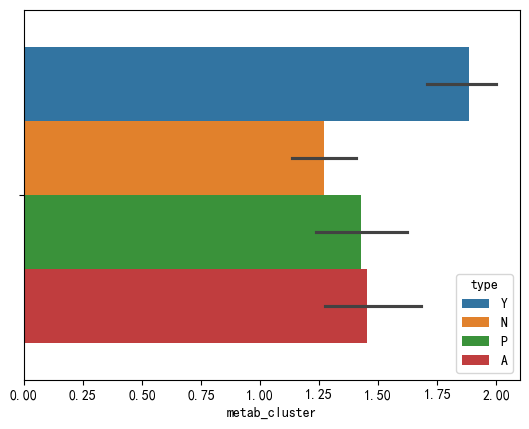

In [41]:
sns.barplot(data=sample_df,x='metab_cluster',hue='type',dodge=True)

<Axes: xlabel='metab_cluster', ylabel='count'>

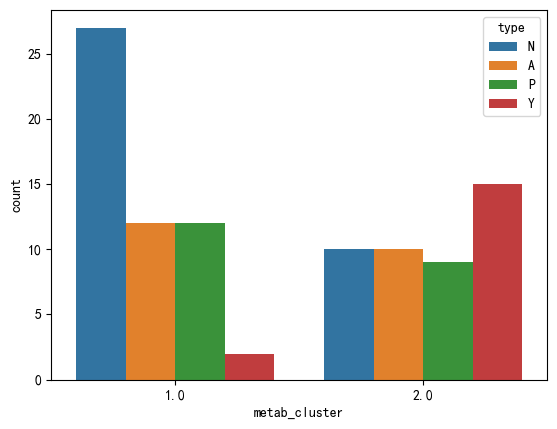

In [42]:
sns.countplot(data=sample_df,x='metab_cluster',hue='type',dodge=True)

<Axes: xlabel='metab_cluster', ylabel='count'>

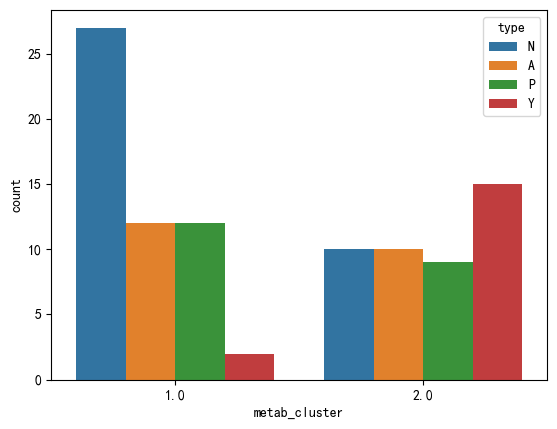

In [43]:
sns.countplot(data=sample_df,x='metab_cluster',hue='type',dodge=True)

In [44]:
import matplotlib
matplotlib.matplotlib_fname()

'/home/suh/anaconda3/envs/MetabSubtype/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'

In [45]:
zhfont1 = matplotlib.font_manager.FontProperties(fname="SimHei.ttf") 
zhfont1

In [46]:
matplotlib.get_cachedir()

'/home/suh/.cache/matplotlib'

In [47]:
# a=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])

# for i in a:
#     print(i)

In [48]:
sample_df.columns

Index(['Unnamed: 0', 'hospital_id', 'Name', 'batch', 'os', 'oss', 'type',
       'TNM', '主要分型', '次要分型', 'RNAseq分型', '尝试分型', '转录组分型', 'rfs', 'rfss',
       'CODEX主要亚型', '克隆', 'MT2结构', 'pTNMs', '生存时间', '状态', '生存时间分组', 'ascl1',
       'codex_new', 'gender', 'age', 'smoke', '病理类型', 'metab_cluster',
       'lipid_cluster'],
      dtype='object')

In [49]:
sample_df.shape

(101, 30)

# Metab

In [50]:


# 定义分段的区间和对应的标签
# bins = np.linspace(10, 100, 10)  # 生成等距离的bins
bins = [0,60,90]  # 生成等距离的bins
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
# 使用pd.cut进行分段
sample_df['age_group'] = pd.cut(sample_df['age'], bins=bins, labels=labels, right=False)
label_counts = sample_df['age_group'].value_counts()

# 过滤掉没有样本落入的标签
valid_labels = label_counts[label_counts > 0].index.tolist()

# 仅保留有效标签的行
sample_df = sample_df[sample_df['age_group'].isin(valid_labels)]
# 显示结果


In [51]:

# 定义分段的区间和对应的标签
bins = np.arange(0, 48, 12)  # 生成等距离的bins
# bins = [0,40,50,60,70,80,90]  # 生成等距离的bins
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
# 使用pd.cut进行分段
sample_df['survival_group'] = pd.cut(sample_df['os'], bins=bins, labels=labels, right=False)
label_counts = sample_df['survival_group'].value_counts()

# 过滤掉没有样本落入的标签
valid_labels = label_counts[label_counts > 0].index.tolist()

# 仅保留有效标签的行
sample_df = sample_df[sample_df['survival_group'].isin(valid_labels)]
# 显示结果
print(sample_df['survival_group'].value_counts())

survival_group
0-12     24
24-36    21
12-24    13
Name: count, dtype: int64


In [52]:
sample_df['age_group'].value_counts()

age_group
60-90    41
0-60     17
Name: count, dtype: int64

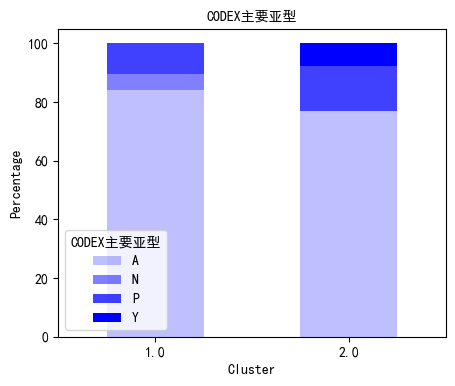

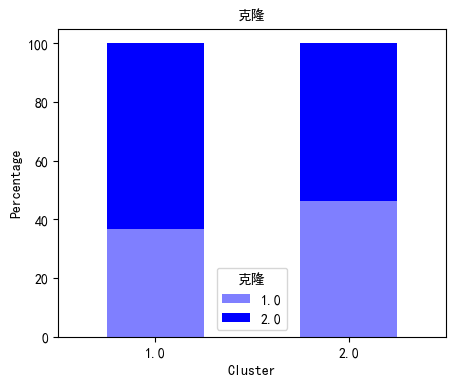

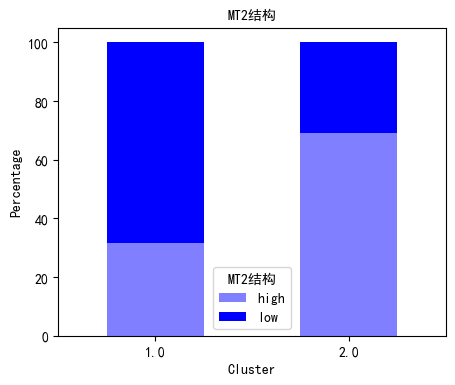

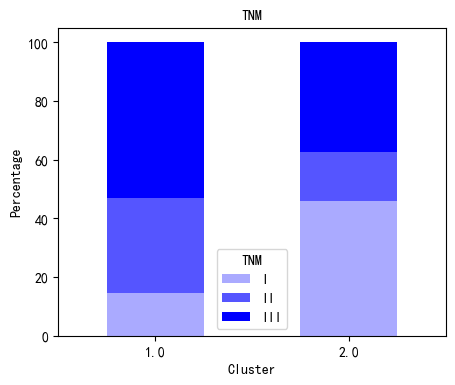

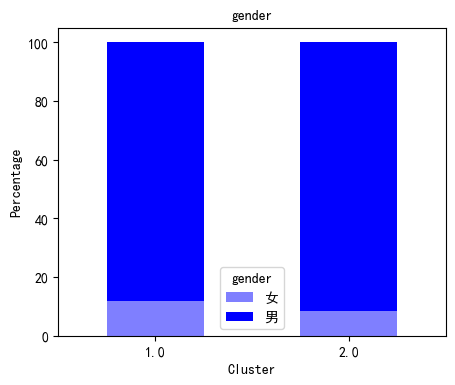

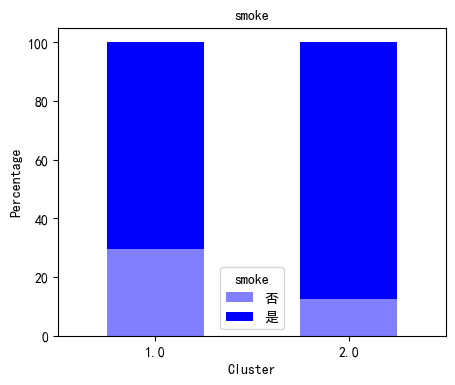

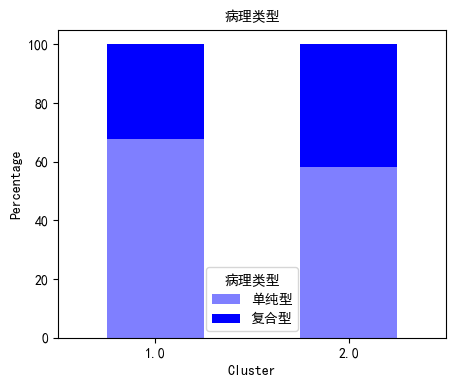

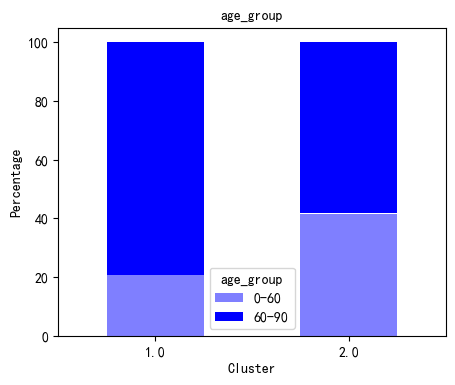

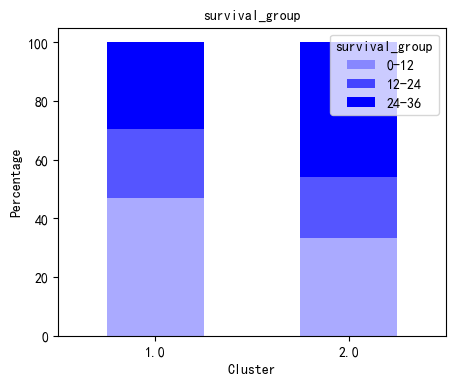

In [54]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 定义渐变色的函数，选择一种颜色（蓝色）生成渐变色
def get_color_gradient(base_color, num_colors):
    return [mcolors.to_rgba(base_color, alpha=1-i/num_colors) for i in range(1, num_colors+1)]

candidate_columns = ['CODEX主要亚型','克隆','MT2结构','TNM','gender','smoke','病理类型','age_group','survival_group']

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 设置字体

for stack_column in candidate_columns:
    using_df = sample_df[(~sample_df[stack_column].isna()) & (sample_df[stack_column] != 'Neg')]

    # Group by 'cluster' and the selected column, then count the occurrences
    grouped = using_df.groupby(['metab_cluster', stack_column]).size().unstack(fill_value=0)
    grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100
    
    # 获取颜色渐变，定义基础颜色为蓝色，这里可以换成其他颜色
    base_color = 'blue'
    num_categories = len(grouped_percentage.columns)
    color_gradient = get_color_gradient(base_color, num_categories)
    
    # Plot the stacked bar chart with custom color gradient
    fig, ax = plt.subplots(figsize=(5, 4))
    grouped_percentage.plot(kind='bar', stacked=True, width=0.5, ax=ax, color=color_gradient)
    
    # Customize the plot
    plt.title(f'{stack_column}', fontproperties=zhfont1)
    plt.xlabel('Cluster', fontproperties=zhfont1)
    plt.ylabel('Percentage', fontproperties=zhfont1)
    plt.xticks(rotation=0)  # 将x轴刻度旋转为0度
    
    # Show the plot
    plt.show()

- histology
- ACT
- CODEX亚型确定
- 免疫微环境
- 湿实验
    - 突变list
- KEGG
    - survival
    - 

### os==1

(array([0, 1]), [Text(0, 0, '1.0'), Text(1, 0, '2.0')])

<Figure size 640x480 with 0 Axes>

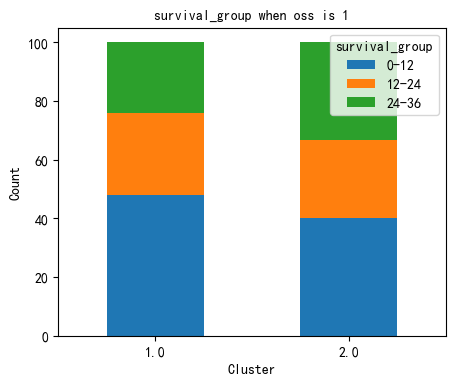

In [20]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]= False #设置字体

stack_column='survival_group'
using_df=sample_df[(~sample_df[stack_column].isna())&(sample_df[stack_column]!=0)]
using_df=using_df[using_df['oss']==1]
# Group by 'cluster' and 'male', then count the occurrences
grouped = using_df.groupby(['metab_cluster', stack_column]).size().unstack(fill_value=0)
grouped
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

plt.set_cmap('Set1')
# Plot the stacked bar chart
# plt.figure(figsize=(2, 4))
fig,ax=plt.subplots()
grouped_percentage.plot(kind='bar', stacked=True,width=0.5,ax=ax,figsize=(5,4))

# Customize the plot
# plt.title(f'Number of {stack_column} per Cluster',fontproperties=zhfont1)
plt.title(f'{stack_column} when oss is 1',fontproperties=zhfont1)
plt.xlabel('Cluster',fontproperties=zhfont1)
plt.ylabel('Count',fontproperties=zhfont1)
# plt.legend(title='Male', labels=['Female', 'Male'])
plt.xticks(rotation=0)  # 将x轴刻度旋转45度
# Show the plot
# plt.show()

(array([0, 1]), [Text(0, 0, '1.0'), Text(1, 0, '2.0')])

<Figure size 640x480 with 0 Axes>

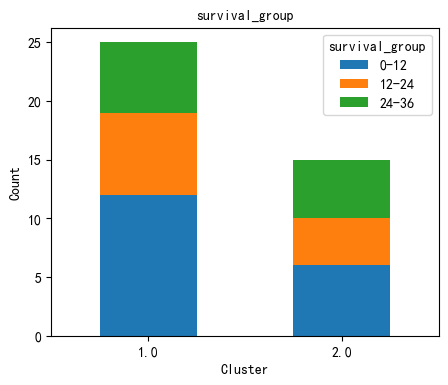

In [21]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]= False #设置字体

stack_column='survival_group'
using_df=sample_df[(~sample_df[stack_column].isna())&(sample_df[stack_column]!=0)]
using_df=using_df[using_df['oss']==1]
# Group by 'cluster' and 'male', then count the occurrences
grouped = using_df.groupby(['metab_cluster', stack_column]).size().unstack(fill_value=0)
grouped
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

plt.set_cmap('Set1')
# Plot the stacked bar chart
# plt.figure(figsize=(2, 4))
fig,ax=plt.subplots()
grouped.plot(kind='bar', stacked=True,width=0.5,ax=ax,figsize=(5,4))

# Customize the plot
# plt.title(f'Number of {stack_column} per Cluster',fontproperties=zhfont1)
plt.title(f'{stack_column}',fontproperties=zhfont1)
plt.xlabel('Cluster',fontproperties=zhfont1)
plt.ylabel('Count',fontproperties=zhfont1)
# plt.legend(title='Male', labels=['Female', 'Male'])
plt.xticks(rotation=0)  # 将x轴刻度旋转45度
# Show the plot
# plt.show()

## Count

<Figure size 640x480 with 0 Axes>

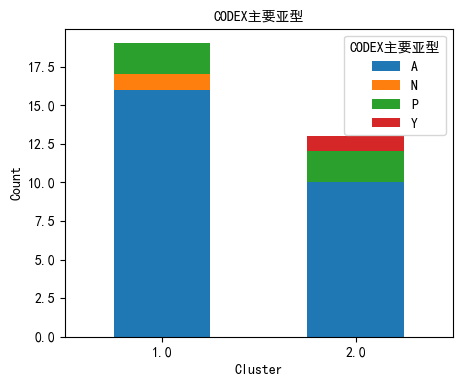

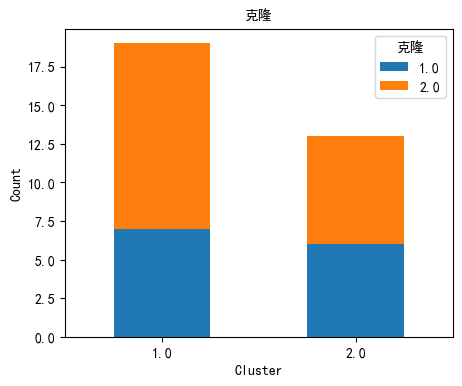

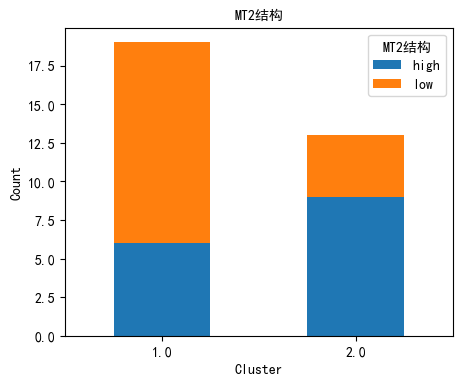

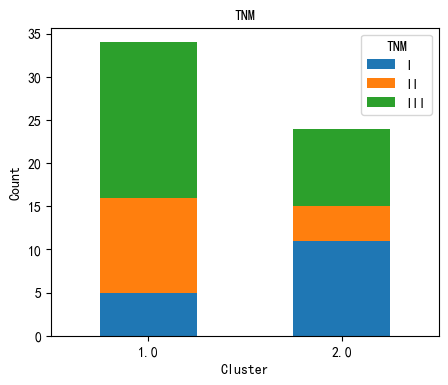

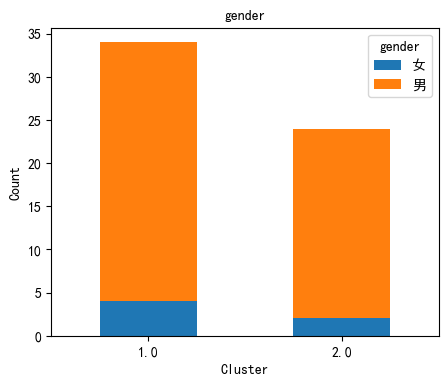

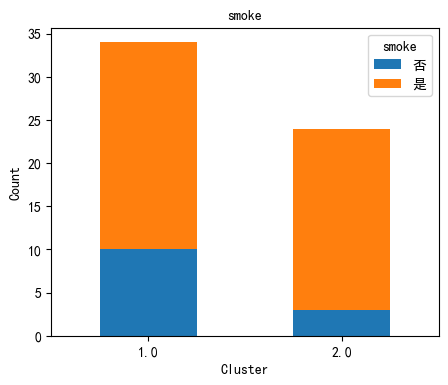

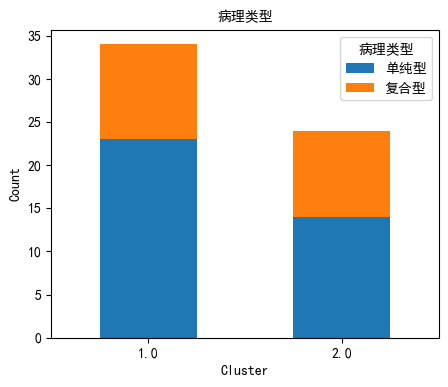

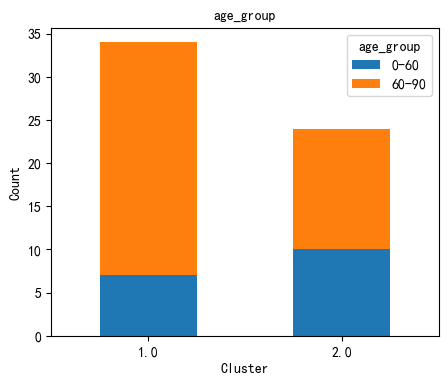

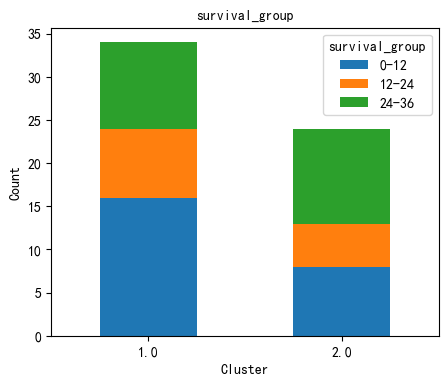

In [22]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]= False #设置字体
stack_column=''
for stack_column in candidate_columns:
    using_df=sample_df[(~sample_df[stack_column].isna())]
# Group by 'cluster' and 'male', then count the occurrences
    grouped = using_df.groupby(['metab_cluster', stack_column]).size().unstack(fill_value=0)
    grouped
    # grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

    plt.set_cmap('Set1')
    # Plot the stacked bar chart
    # plt.figure(figsize=(2, 4))
    fig,ax=plt.subplots()
    grouped.plot(kind='bar', stacked=True,width=0.5,ax=ax,figsize=(5,4))
    
    # Customize the plot
    # plt.title(f'Number of {stack_column} per Cluster',fontproperties=zhfont1)
    plt.title(f'{stack_column}',fontproperties=zhfont1)
    plt.xlabel('Cluster',fontproperties=zhfont1)
    plt.ylabel('Count',fontproperties=zhfont1)
    # plt.legend(title='Male', labels=['Female', 'Male'])
    plt.xticks(rotation=0)  # 将x轴刻度旋转45度
    # Show the plot
    # plt.show()

In [23]:
sample_df['age_group'].value_counts()

age_group
60-90    41
0-60     17
Name: count, dtype: int64

<Axes: xlabel='lipid_cluster', ylabel='count'>

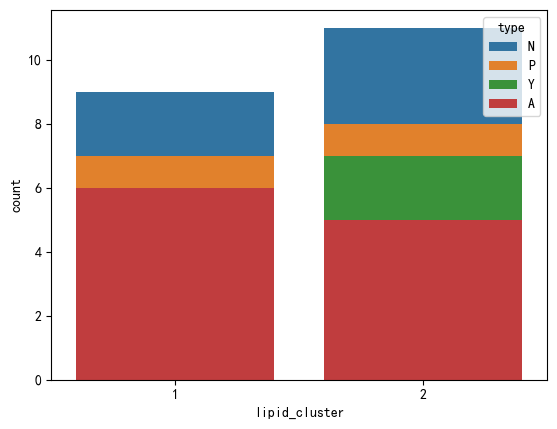

In [24]:
sns.countplot(data=sample_df,x='lipid_cluster',hue='type',dodge=False)

# Lipid

<Figure size 640x480 with 0 Axes>

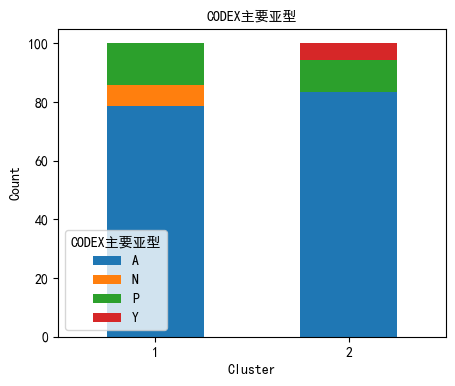

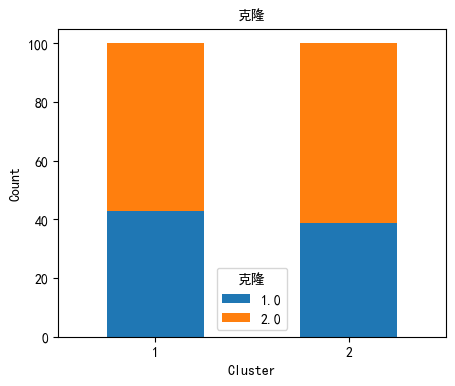

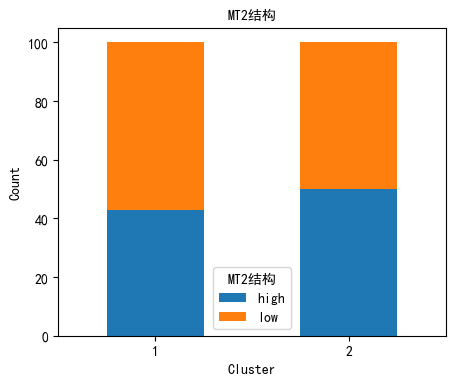

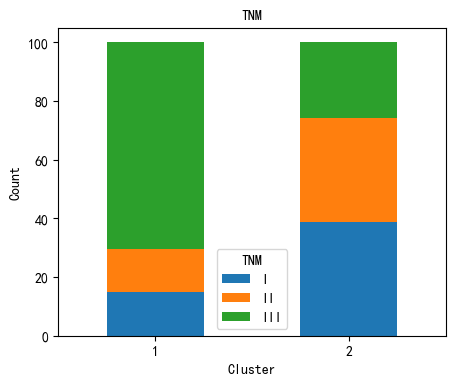

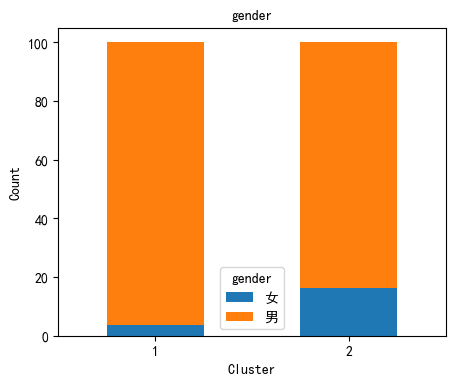

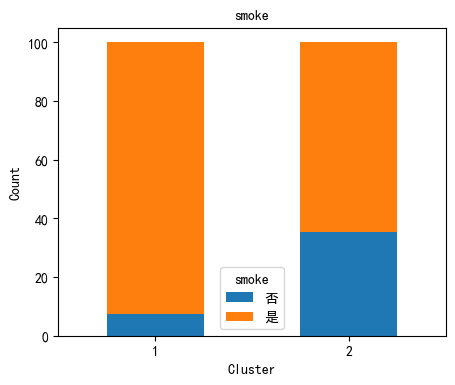

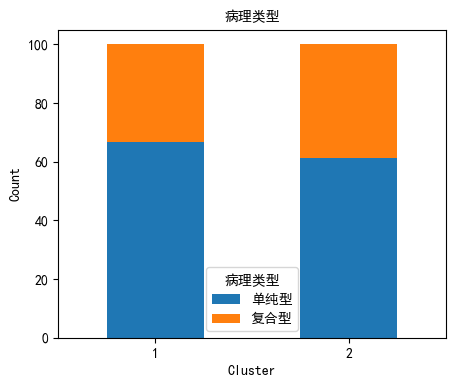

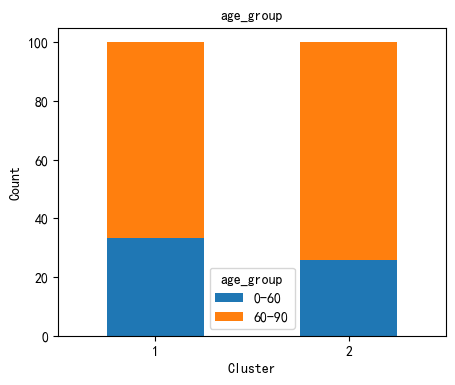

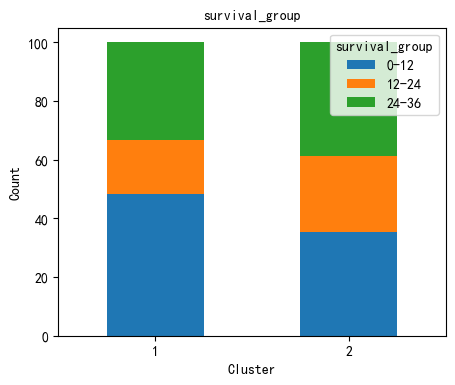

In [25]:
candidate_columns=['CODEX主要亚型','克隆','MT2结构','TNM','gender','smoke','病理类型','age_group','survival_group']
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]= False #设置字体
stack_column=''
for stack_column in candidate_columns:
    using_df=sample_df[(~sample_df[stack_column].isna())&(sample_df[stack_column]!=0)]
# Group by 'cluster' and 'male', then count the occurrences
    grouped = using_df.groupby(['lipid_cluster', stack_column]).size().unstack(fill_value=0)
    grouped
    grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

    plt.set_cmap('Set1')
    # Plot the stacked bar chart
    # plt.figure(figsize=(2, 4))
    fig,ax=plt.subplots()
    grouped_percentage.plot(kind='bar', stacked=True,width=0.5,ax=ax,figsize=(5,4))
    
    # Customize the plot
    # plt.title(f'Number of {stack_column} per Cluster',fontproperties=zhfont1)
    plt.title(f'{stack_column}',fontproperties=zhfont1)
    plt.xlabel('Cluster',fontproperties=zhfont1)
    plt.ylabel('Count',fontproperties=zhfont1)
    # plt.legend(title='Male', labels=['Female', 'Male'])
    plt.xticks(rotation=0)  # 将x轴刻度旋转45度
    # Show the plot
    # plt.show()

(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '2')])

<Figure size 640x480 with 0 Axes>

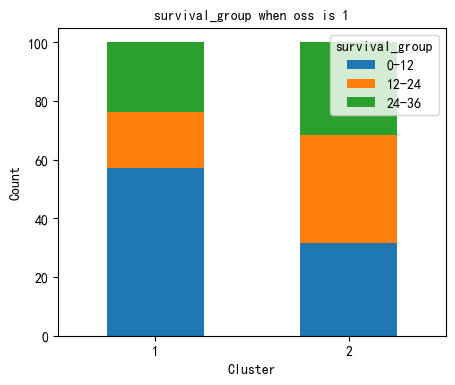

In [26]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]= False #设置字体

stack_column='survival_group'
using_df=sample_df[(~sample_df[stack_column].isna())&(sample_df[stack_column]!=0)]
using_df=using_df[using_df['oss']==1]
# Group by 'cluster' and 'male', then count the occurrences
grouped = using_df.groupby(['lipid_cluster', stack_column]).size().unstack(fill_value=0)
grouped
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

plt.set_cmap('Set1')
# Plot the stacked bar chart
# plt.figure(figsize=(2, 4))
fig,ax=plt.subplots()
grouped_percentage.plot(kind='bar', stacked=True,width=0.5,ax=ax,figsize=(5,4))

# Customize the plot
# plt.title(f'Number of {stack_column} per Cluster',fontproperties=zhfont1)
plt.title(f'{stack_column} when oss is 1',fontproperties=zhfont1)
plt.xlabel('Cluster',fontproperties=zhfont1)
plt.ylabel('Count',fontproperties=zhfont1)
# plt.legend(title='Male', labels=['Female', 'Male'])
plt.xticks(rotation=0)  # 将x轴刻度旋转45度
# Show the plot
# plt.show()